# Bio-Image Analysis Workflow
This notebook focuses on processing a set of biological images and their corresponding label images. The following tasks will be addressed:
* Develop an image-segmentation workflow
* Extract features from these images
* Visualize relationships between these features
* Find out which features are strongly correlated and which not
The data used comes from the BBBC007v1 image set version 1 (Jones et al., 2005), available from the Broad Bioimage Benchmark Collection (Ljosa et al., Nature Methods, 2012).

## Planned Steps
1. Import necessary libraries
2. Load images and corresponding label images
3. Develop and apply a segmentation algorithm
4. Evaluate segmentation results using the Jaccard index
5. Extract features from segmentation results
6. Visualize relationships between extracted features
7. Identify strongly correlated features
8. Save segmentation results and features

In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import skimage.io
import skimage.segmentation
import skimage.morphology
import skimage.measure
import matplotlib.pyplot as plt
from stackview import imshow
from the_segmentation_game import metrics
import seaborn as sns
from scipy.stats import pearsonr
from skimage.filters import gaussian, threshold_otsu

### Installation Instructions
To reproduce the environment, you can use the following commands:

```sh
# Using pip
pip install numpy pandas scikit-image matplotlib seaborn stackview the_segmentation_game
```

```sh
# Using conda
conda install numpy pandas scikit-image matplotlib seaborn
pip install stackview the_segmentation_game
```

### Loading Images and Corresponding Label Images
We'll load the images and their corresponding label images from the specified folders. These images will be used for segmentation and feature extraction.

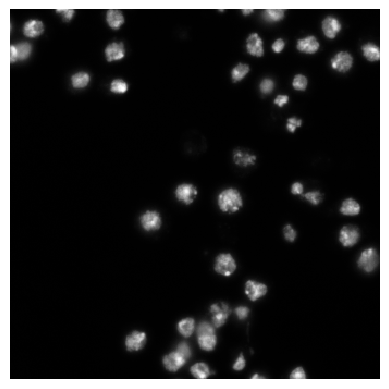

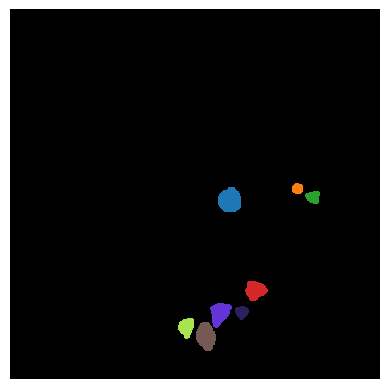

In [2]:
# Load images and corresponding label images
image_folder = '../05b_quality_assurance/data/BBBC007_batch/'
label_folder = '../05b_quality_assurance/data/BBBC007_sparse_instance_annotation/'

image_files = [f for f in os.listdir(image_folder) if f.endswith('.tif')]
label_files = [f for f in os.listdir(label_folder) if f.endswith('.tif')]

images = {f: skimage.io.imread(os.path.join(image_folder, f)) for f in image_files}
labels = {f: skimage.io.imread(os.path.join(label_folder, f)) for f in label_files}

# Display first image and label for verification
first_image_key = list(images.keys())[0]
imshow(images[first_image_key])
imshow(labels[first_image_key])


### Segmentation Algorithm
We will use a combination of Gaussian filtering, Otsu's thresholding, and morphological operations for segmentation. The process includes smoothing the image, binarization using Otsu's method, and filling holes to identify objects.

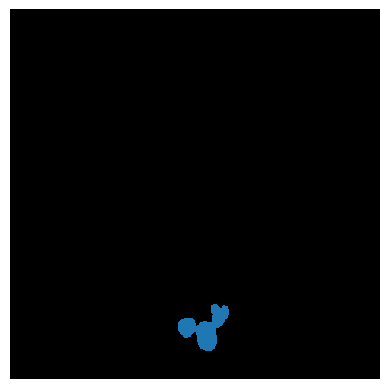

In [3]:
# Apply segmentation algorithm
segmented_images = {}

for fname, image in images.items():
    # Apply Gaussian filter
    smoothed = gaussian(image, sigma=1)
    
    # Apply Otsu's threshold
    threshold = threshold_otsu(smoothed)
    binary = smoothed > threshold
    
    # Fill holes and remove small objects
    cleaned = skimage.morphology.remove_small_objects(skimage.morphology.remove_small_holes(binary, area_threshold=500), min_size=500)
    
    # Label the segmented image
    labeled = skimage.morphology.label(cleaned)
    segmented_images[fname] = labeled

# Display the first segmented image
imshow(segmented_images[first_image_key])


### Quality Evaluation
We will evaluate the segmentation results using the Jaccard index, which measures the similarity between the predicted segmentations and the reference segmentations.

In [4]:
# Evaluate segmentation results
jaccard_indices = {}

for fname, segmented in segmented_images.items():
    reference = labels[fname]
    jaccard_indices[fname] = metrics.jaccard_index_sparse(reference, segmented)

jaccard_df = pd.DataFrame(list(jaccard_indices.items()), columns=['File', 'Jaccard_Index'])
display(jaccard_df)


,File,Jaccard_Index
0,17P1_POS0013_D_1UL.tif,0.105818
1,20P1_POS0005_D_1UL.tif,0.105378
2,20P1_POS0007_D_1UL.tif,0.000000
3,20P1_POS0010_D_1UL.tif,0.000000
4,A9 p7d.tif,0.217541
5,AS_09125_040701150004_A02f00d0.tif,0.037195


### Feature Extraction
Using the segmentation results, we will extract features such as area, perimeter, and intensity from each segmented object.

In [5]:
# Extract features from segmentation results
features = []

for fname, segmented in segmented_images.items():
    image = images[fname]
    region_props = skimage.measure.regionprops(segmented, intensity_image=image)
    for region in region_props:
        features.append({
            'File': fname,
            'Label': region.label,
            'Area': region.area,
            'Perimeter': region.perimeter,
            'Mean_Intensity': region.mean_intensity,
        })

features_df = pd.DataFrame(features)
display(features_df.head())


,File,Label,Area,Perimeter,Mean_Intensity
0,17P1_POS0013_D_1UL.tif,1,922.0,180.610173,94.078091
1,20P1_POS0005_D_1UL.tif,1,788.0,136.468037,101.696701
2,20P1_POS0007_D_1UL.tif,1,501.0,97.012193,97.203593
3,20P1_POS0007_D_1UL.tif,2,576.0,111.154329,85.439236
4,20P1_POS0007_D_1UL.tif,3,518.0,109.154329,85.449807


### Visualization of Feature Relationships
We will visualize the relationships between the extracted features using pair plots.

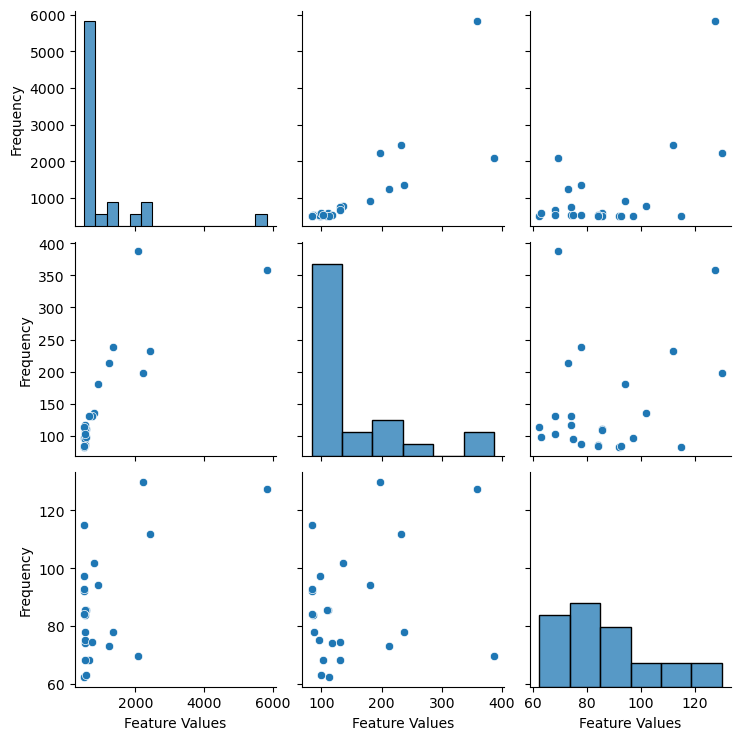

In [6]:
# Visualize relationships between features
plot = sns.pairplot(features_df[['Area', 'Perimeter', 'Mean_Intensity']])
plot.set(xlabel='Feature Values', ylabel='Frequency')
plt.show()


### Correlation Analysis
We will compute the Pearson correlation coefficients to identify which features are strongly correlated.

In [7]:
# Find strongly correlated features
correlations = features_df[['Area', 'Perimeter', 'Mean_Intensity']].corr(method='pearson')
print(correlations)


                    Area  Perimeter  Mean_Intensity
Area            1.000000   0.816257        0.568580
Perimeter       0.816257   1.000000        0.252701
Mean_Intensity  0.568580   0.252701        1.000000


### Saving Results
Finally, we will save the segmentation results as label images and the extracted features as a CSV file.

In [8]:
# Save segmentation results and extracted features
output_label_folder = '../05b_quality_assurance/output/segmentation/' 
output_features_file = '../05b_quality_assurance/output/features.csv'

if not os.path.exists(output_label_folder):
    os.makedirs(output_label_folder)

for fname, segmented in segmented_images.items():
    skimage.io.imsave(os.path.join(output_label_folder, fname), segmented)

features_df.to_csv(output_features_file, index=False)
print('Segmentation results and features have been saved.')

Segmentation results and features have been saved.


C:\Users\haase\AppData\Local\Temp\ipykernel_19048\2835117606.py:9: UserWarning: ../05b_quality_assurance/output/segmentation/17P1_POS0013_D_1UL.tif is a low contrast image
  skimage.io.imsave(os.path.join(output_label_folder, fname), segmented)
C:\Users\haase\AppData\Local\Temp\ipykernel_19048\2835117606.py:9: UserWarning: ../05b_quality_assurance/output/segmentation/20P1_POS0005_D_1UL.tif is a low contrast image
  skimage.io.imsave(os.path.join(output_label_folder, fname), segmented)
C:\Users\haase\AppData\Local\Temp\ipykernel_19048\2835117606.py:9: UserWarning: ../05b_quality_assurance/output/segmentation/20P1_POS0007_D_1UL.tif is a low contrast image
  skimage.io.imsave(os.path.join(output_label_folder, fname), segmented)
C:\Users\haase\AppData\Local\Temp\ipykernel_19048\2835117606.py:9: UserWarning: ../05b_quality_assurance/output/segmentation/20P1_POS0010_D_1UL.tif is a low contrast image
  skimage.io.imsave(os.path.join(output_label_folder, fname), segmented)
C:\Users\haase\AppDa

# References
* Jones, T. R., Kang, I. H., Wheeler, D. B., Lindquist, R. A., Papallo, A., Sabatini, D. M., Golland, P., & Carpenter, A. E. (2005). CellProfiler: open-source software for automated biological image analysis. Proceedings of the ICCV Workshop on Computer Vision for Biomedical Image Applications, 2005.
* Ljosa, V., Sokolnicki, K. L., & Carpenter, A. E. (2012). Annotated high-throughput microscopy image sets for validation. Nature Methods, 9(7), 637-638.